In [19]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from connection_keys import connect_bq_client
import statsmodels.api as sm
import os
import warnings
import itertools
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.set_option('display.max_colwidth', None)

# Puxando dados do BQ
Puxando dados do BigQuery

In [2]:
client = connect_bq_client()

sql = """
    SELECT *
    FROM `db_market_product.gpu`
    ORDER BY dt_carga asc
"""

df = client.query(sql).to_dataframe()
df['data'] = df.dt_carga.dt.date
df['ds_nome_produto'] = df['ds_nome_produto'].str.upper()

# First Look
Dando uma primeira olhada nos dados salvos

In [3]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570178 entries, 0 to 570177
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    570178 non-null  object             
 1   ds_nome_produto             570178 non-null  object             
 2   vl_preco_atual              570178 non-null  float64            
 3   vl_preco_com_desconto       570178 non-null  float64            
 4   vl_porcentagem_do_desconto  570178 non-null  float64            
 5   qt_quantidade_estoque       213220 non-null  Int64              
 6   oferta                      570178 non-null  object             
 7   ds_disponibilidade          570178 non-null  object             
 8   loja                        570178 non-null  object             
 9   dt_carga                    570178 non-null  datetime64[ns, UTC]
 10  data                        570178 non-null 

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data
341746,Mancer,"PLACA DE VIDEO MANCER RADEON RX 550, 4GB, GDDR...",1446.07,1446.07,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-11-28 22:01:34.892903+00:00,2022-11-28
75346,EVGA,PLACA DE VIDEO EVGA GEFORCE GTX 1080 8GB GDDR5...,2742.98,2742.98,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-12 22:27:35.091882+00:00,2022-10-12
221493,AsRock,PLACA DE VIDEO ASROCK RADEON RX 5600 XT 6GB CH...,2386.32,2386.32,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-11-06 10:06:16.272256+00:00,2022-11-06
414129,Asus,PLACA DE VIDEO ASUS GEFORCE GTX 1080 TI 11GB G...,4899.99,4899.99,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-11 22:01:32.006355+00:00,2022-12-11
417582,PCYES,"PLACA DE VÍDEO GT 730 PCYES NVIDIA GEFORCE, 4G...",552.93,469.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_...",False,Kabum,2022-12-12 22:01:42.230963+00:00,2022-12-12


In [4]:
df.isnull().sum()

ds_marca                           0
ds_nome_produto                    0
vl_preco_atual                     0
vl_preco_com_desconto              0
vl_porcentagem_do_desconto         0
qt_quantidade_estoque         356958
oferta                             0
ds_disponibilidade                 0
loja                               0
dt_carga                           0
data                               0
dtype: int64

In [5]:
columns = ["ds_marca", "ds_disponibilidade", "loja", "oferta"]

for column in columns:
  print(df[column].unique())

['Nvidia' 'Gigabyte' 'Colorful' 'Asus' 'PALIT' 'Afox' 'Gainward' 'Pny'
 'PCYES' 'GOLDENTEC' 'Axle' 'MSI' 'Liketec' 'Galax' 'Knup' 'DT3sports'
 'GOLINE' 'Lian Li' 'Hp' 'imperiums' 'Duex' 'Bluecase' 'PCWINMAX'
 'Riser Card' '5TECHPC' 'Powercolor' 'Zotac' 'DEX' 'DarkFlash' 'Outros'
 'Evga' 'OFICINA DOS BITS' 'Cooler Master' 'Brazil PC' 'Thermaltake'
 'Barrow' 'Arktek' 'XFX' 'Biostar' 'Amd' 'Ctech' 'Deepcool' 'Valianty'
 'Grizzly' 'Power Color' 'ASRock' 'PNY' 'AMD' 'AFOX' 'ZOGIS' 'EVGA'
 'PCYES!' 'Sapphire' 'Mancer' 'PowerColor' 'AsRock' 'Enzatec' 'Akasa'
 'Rise Mode' 'Gibayte' 'PNY Technologies' 'Aorus' 'Zogis' 'Point'
 'Genérica' 'Inno 3d' 'NEOLOGIC']
['False' 'True' 'OUT_OF_STOCK' 'IN_STOCK']
['Kabum' 'Pichau']
['None'
 "[{'ds_oferta_nome': 'Setembro Tech', 'vl_oferta_preco_atual': 359.1, 'vl_oferta_preco_com_desconto': 359.1, 'vl_oferta_porcentagem_do_desconto': 9}]"
 "[{'ds_oferta_nome': 'Setembro Tech', 'vl_oferta_preco_atual': 749.88, 'vl_oferta_preco_com_desconto': 749.88, 'vl_ofer

# Explorando os dados

Como o processo roda duas vezes ao dia, vale a verificação se houve algum dia em que foi rodado mais vezes no mesmo dia.

In [6]:
df_verification_days = df.groupby(['data', 'loja'])['dt_carga'].nunique().reset_index(name='counts')
df_verification_days.query("counts > 2")

,data,loja,counts
26,2022-10-12,Kabum,4
27,2022-10-12,Pichau,4
28,2022-10-13,Kabum,3
29,2022-10-13,Pichau,3
30,2022-10-14,Kabum,3
31,2022-10-14,Pichau,3
32,2022-10-15,Kabum,3
33,2022-10-15,Pichau,3
34,2022-10-16,Kabum,3
35,2022-10-16,Pichau,3


Como pode ser visto, na coluna "ds_disponibilidade" existem diferentes formas de dizer se um item está em estoque atualmente ou não, a forma como isso é apresentado depende da loja, para que em ambas as lojas a informação fique equalizada, será alterado os tipos "OUT_OF_STOCK" e "IN_STOCK" para true e false.

In [7]:
# Alterando o campo "ds_disponibilidade" para booleano
df['ds_disponibilidade'].replace(["OUT_OF_STOCK", "IN_STOCK"], [False, True],inplace=True)
df['ds_disponibilidade'] = df['ds_disponibilidade'].astype(bool)

Para ficar mais fácil de filtrar as placas de vídeo em si de outros produtos que estão presentes, a partir de um padrão de informação, será criado um campo novo com a descrição resumida do nome da placa.
<p><b>EVOLUÇÃO: PEGAR O NOME DA PLACA UTILIZANDO TÉNICAS DE NLP</b></p>

In [17]:
def get_resume_product_name(name):
  """
    Description: Com base no padrão de nomenclatura das placas de vídeo, cria um novo
    campo com o nome abreviado do modelo.
  """
  pattern = "(RTX|GTX|GT|RX|WX|QUADRO|R7|R5|R9|HD)(.?.?)((\w*)\d+)( ?(TI|XT|X|SUPER))?"
  resume_name = re.search(pattern, name)
  if resume_name is None:
      return None
  else:
      return resume_name.group().strip()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

Efetua a separação e filtragem do dataframe atraves das datas do dia, pegando apenas a última leitura do dia para a análise, mas salva as primeiras datas para possíveis comprações de datas dentro do mesmo dia.

In [76]:
maxDf = df.groupby(['data'])['dt_carga'].max()
minDf = df.groupby(['data'])['dt_carga'].min()
maxDates = maxDf.tolist()
minDates = minDf.tolist()
df_max = df.loc[df['dt_carga'].isin(maxDates)]
df_min = df.loc[df['dt_carga'].isin(minDates)]

Filtra o dataset para ter apenas os produtos com nomes válidos de placa

In [77]:
df_gpu = df_max.loc[~df_max.ds_nome_produto_resumido.isnull()]
print(f"""Tamanho do dataframe com todos os produtos: {df_max.shape[0]} \nTamanho do dataframe apenas com produtos válidos: {df_gpu.shape[0]}""")


Tamanho do dataframe com todos os produtos: 273290 
Tamanho do dataframe apenas com produtos válidos: 265753


Análise de variação de preço ao longo do tempo para o valor base e o valor com desconto

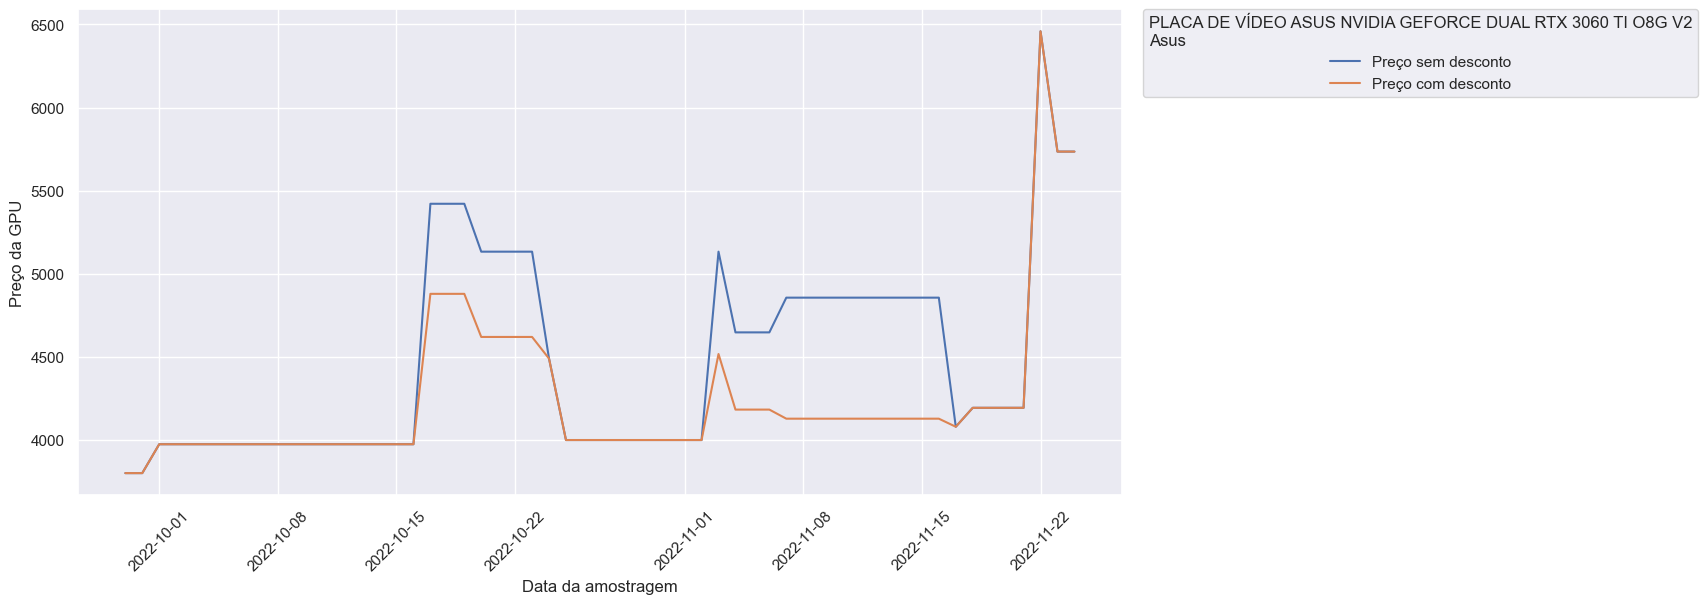

In [153]:
# query_gpu.
index = 8
product_name = "RTX 3060 TI"
store = "Kabum"

query_gpu_line = df_gpu.query(f""" ds_nome_produto_resumido == "{product_name}" and loja == "{store}" """).iloc[index]
query_gpu_line.drop_duplicates(keep="first")

gpu_name = query_gpu_line.ds_nome_produto
brand_name = query_gpu_line.ds_marca

query_gpu = df_gpu.query(f""" ds_nome_produto == "{gpu_name}" and loja == "{store}" """)

sns.set(rc={'figure.figsize':(12,6)})
plt.xticks(rotation = 45)
sns.lineplot(x="data", y="vl_preco_atual", data=query_gpu, label='Preço sem desconto')
sns.lineplot(x="data", y="vl_preco_com_desconto", data=query_gpu, label='Preço com desconto')
plt.ylabel("Preço da GPU")
plt.xlabel("Data da amostragem")
plt.legend(bbox_to_anchor=(1.02, 1),borderaxespad=0, title=f"{re.match('[^,]+', gpu_name).group(0)}\n{brand_name}");

In [116]:
df_gpu.query(""" ds_nome_produto_resumido == "RTX 2060 SUPER" and loja == "Kabum" """).iloc[index]


ds_marca                                                                                        Colorful
ds_nome_produto               PLACA DE VIDEO COLORFUL GEFORCE RTX 2060 SUPER NB, V2-V 8GB, GDDR6, 256BIT
vl_preco_atual                                                                                    2379.0
vl_preco_com_desconto                                                                             2379.0
vl_porcentagem_do_desconto                                                                           0.0
qt_quantidade_estoque                                                                                104
oferta                                                                                              None
ds_disponibilidade                                                                                  True
loja                                                                                               Kabum
dt_carga                                               

<AxesSubplot: xlabel='data', ylabel='vl_preco_atual'>

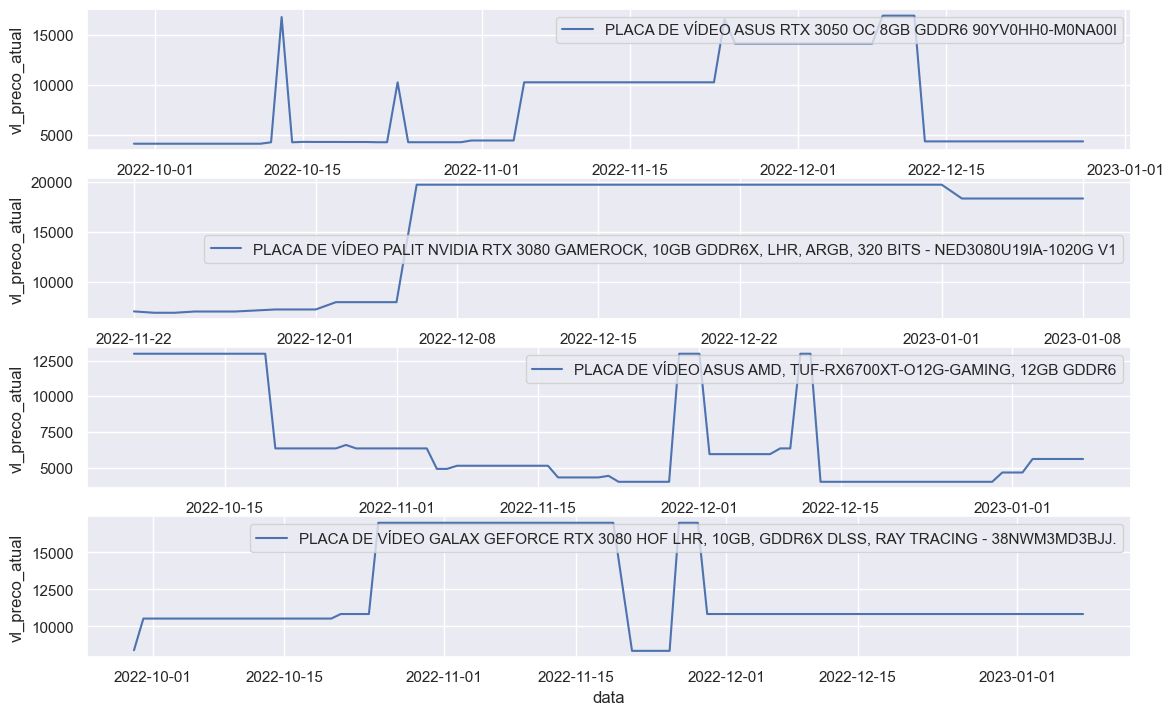

In [188]:
query_dif = df_gpu.sort_values('data').set_index('data').groupby(['ds_nome_produto', "loja"]).apply(lambda x: x['vl_preco_atual'].diff()).reset_index().nlargest(4, "vl_preco_atual")
fig, axes = plt.subplots(4)
sns.set(rc={'figure.figsize':(12,8)})

graph_1 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[0].ds_nome_produto}" and loja == "{query_dif.iloc[0].loja}" """)
graph_2 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[1].ds_nome_produto}" and loja == "{query_dif.iloc[1].loja}" """)
graph_3 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[2].ds_nome_produto}" and loja == "{query_dif.iloc[2].loja}" """)
graph_4 = df_gpu.query(f""" ds_nome_produto == "{query_dif.iloc[3].ds_nome_produto}" and loja == "{query_dif.iloc[3].loja}" """)

sns.lineplot(x="data", y="vl_preco_atual", data=graph_1, label=f"{query_dif.iloc[0].ds_nome_produto}", ax=axes[0])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_2, label=f"{query_dif.iloc[1].ds_nome_produto}", ax=axes[1])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_3, label=f"{query_dif.iloc[2].ds_nome_produto}", ax=axes[2])
sns.lineplot(x="data", y="vl_preco_atual", data=graph_4, label=f"{query_dif.iloc[3].ds_nome_produto}", ax=axes[3])


In [169]:
query_dif.iloc[0].ds_nome_produto

ds_nome_produto    PLACA DE VÍDEO ASUS RTX 3050 OC 8GB GDDR6 90YV0HH0-M0NA00I
loja                                                                    Kabum
data                                                               2022-10-13
vl_preco_atual                                                       12499.13
Name: 195085, dtype: object

In [140]:
df.iloc[df.index == 187159]['ds_nome_produto'].tolist() # ds_nome_produto_resumido ds_nome_produto

['PLACA DE VÍDEO ASUS KO NVIDIA GEFORCE RTX3070 V2 GAMING, RGB, 14 GBPS, 8GB GDDR6, DLSS, LHR, RAY TRACING - KO-RTX3070-08G-V2-GAMING']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384100 entries, 0 to 384099
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    384100 non-null  object             
 1   ds_nome_produto             384100 non-null  object             
 2   vl_preco_atual              384100 non-null  float64            
 3   vl_preco_com_desconto       384100 non-null  float64            
 4   vl_porcentagem_do_desconto  384100 non-null  float64            
 5   qt_quantidade_estoque       142715 non-null  Int64              
 6   oferta                      384100 non-null  object             
 7   ds_disponibilidade          384100 non-null  object             
 8   loja                        384100 non-null  object             
 9   dt_carga                    384100 non-null  datetime64[ns, UTC]
 10  data                        384100 non-null 

,data,loja,counts
26,2022-10-12,Kabum,4
27,2022-10-12,Pichau,4
28,2022-10-13,Kabum,3
29,2022-10-13,Pichau,3
30,2022-10-14,Kabum,3
31,2022-10-14,Pichau,3
32,2022-10-15,Kabum,3
33,2022-10-15,Pichau,3
34,2022-10-16,Kabum,3
35,2022-10-16,Pichau,3


In [14]:
# df_datas_loja = df.groupby(['data', 'loja'])['dt_carga'].nunique()
# df_datas_loja


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
# nltk.download('popular') # Rodar apenas uma vez para fazer a instalação


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/igorferreira/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.

True

In [10]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent
ex = "PLACA DE VÍDEO ASUS NVIDIA GEFORCE GTX 1050 TI OC CERBERUS, 4GB GDDR5 - CERBERUS-GTX1050TI-O4G"
sent = preprocess(ex)
sent
pattern = 'NP: {<NNP>*<CD>*<NNP>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  (NP
    PLACA/NNP
    DE/NNP
    VÍDEO/NNP
    ASUS/NNP
    NVIDIA/NNP
    GEFORCE/NNP
    GTX/NNP
    1050/CD
    TI/NNP)
  (NP OC/NNP CERBERUS/NNP)
  ,/,
  (NP 4GB/CD GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [13]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(ex)))
print(ne_tree)

[('PLACA', 'NNP', 'B-NP'),
 ('DE', 'NNP', 'I-NP'),
 ('VÍDEO', 'NNP', 'I-NP'),
 ('ASUS', 'NNP', 'I-NP'),
 ('NVIDIA', 'NNP', 'I-NP'),
 ('GEFORCE', 'NNP', 'I-NP'),
 ('GTX', 'NNP', 'I-NP'),
 ('1050', 'CD', 'I-NP'),
 ('TI', 'NNP', 'I-NP'),
 ('OC', 'NNP', 'B-NP'),
 ('CERBERUS', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('4GB', 'CD', 'B-NP'),
 ('GDDR5', 'NNP', 'I-NP'),
 ('-', ':', 'O'),
 ('CERBERUS-GTX1050TI-O4G', 'NN', 'O')]
(S
  (ORGANIZATION PLACA/NNP)
  (PERSON DE/NNP)
  VÍDEO/NNP
  ASUS/NNP
  NVIDIA/NNP
  GEFORCE/NNP
  GTX/NNP
  1050/CD
  TI/NNP
  OC/NNP
  CERBERUS/NNP
  ,/,
  4GB/CD
  (ORGANIZATION GDDR5/NNP)
  -/:
  CERBERUS-GTX1050TI-O4G/NN)


In [5]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)\s(\d+)"
    resume_name = re.search(pattern, name)
    if resume_name is None:
        return ''
    else:
        return resume_name.group()

df['ds_nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['ds_nome_produto']), axis=1)

In [17]:
df.sample(10)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data
45913,XFX,"PLACA DE VIDEO XFX RADEON R7 360 2GB GDDR5 128-BIT, R7-360P-2DF5",576.15,576.15,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-07 22:01:28.788032+00:00,2022-10-07
389705,Galax,"PLACA DE VÍDEO, NVIDIA GALAX GEFORCE, GTX 1630 4GB, DDR6, 64 BITS",1021.59,970.51,5.0,26,None,True,Kabum,2022-12-07 22:01:41.943312+00:00,2022-12-07
297416,Evga,PLACA DE VIDEO RTX 3060 TI 8GB GDDR6 256BITS DUAL FAN 08G-P5-3663-KL EVGA,5395.90,4586.51,15.0,0,None,False,Kabum,2022-11-20 22:02:00.222487+00:00,2022-11-20
254406,Pny,"PLACA DE VIDEO PNY NVIDIA QUADRO T1000, 4GB, GDDR6, 128 BITS, LOW PROFILE - VCNT1000-PORPB",3437.59,3265.71,5.0,0,None,False,Kabum,2022-11-12 22:01:49.274075+00:00,2022-11-12
440210,MSI,PLACA DE VÍDEO MSI GEFORCE GTX 1060 ARMOR 6G OCV1 GDDR5 192BIT,1541.00,1541.00,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-12-16 22:01:23.029774+00:00,2022-12-16
534484,Asus,"PLACA DE VÍDEO GTX 1660 ASUS PHOENIX NVIDIA GEFORCE 6GB, GDDR5 - PH-GTX1660-O6G",2941.16,2499.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 2852.93, 'vl_oferta_preco_com_desconto': 2424.99, 'vl_oferta_porcentagem_do_desconto': 2}]",False,Kabum,2023-01-02 22:01:51.287766+00:00,2023-01-02
212028,AMD,"PLACA DE VIDEO AFOX RADEON RX 550 4GB 128-BIT, AFRX550-4096D5H3",737.52,737.52,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-11-04 22:01:26.935871+00:00,2022-11-04
444865,Knup,"PLACA DE VÍDEO PARA PC DESKTOP, 2GB, DDR3, 64BIT, VGA HDMI, NVIDIA GEFORCE KNUP - KP-GT730/BB",549.80,549.80,0.0,1000,None,True,Kabum,2022-12-17 22:01:36.828901+00:00,2022-12-17
291830,PCYES,"PLACA DE VIDEO AMD RX 6600 8GB GDDR6 128 BITS,GRAFFITI",3096.00,3096.00,0.0,0,None,False,Kabum,2022-11-19 22:01:54.279758+00:00,2022-11-19
169549,EVGA,"PLACA DE VIDEO EVGA GEFORCE GT 740 2GB FTW GDDR5, 128BIT, 02G-P4-3744-KR - BOX",586.00,586.00,12.0,<NA>,None,OUT_OF_STOCK,Pichau,2022-10-27 22:02:29.876756+00:00,2022-10-27


In [16]:
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267687 entries, 2663 to 556112
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   ds_marca                    267687 non-null  object             
 1   ds_nome_produto             267687 non-null  object             
 2   vl_preco_atual              267687 non-null  float64            
 3   vl_preco_com_desconto       267687 non-null  float64            
 4   vl_porcentagem_do_desconto  267687 non-null  float64            
 5   qt_quantidade_estoque       101224 non-null  Int64              
 6   oferta                      267687 non-null  object             
 7   ds_disponibilidade          267687 non-null  object             
 8   loja                        267687 non-null  object             
 9   dt_carga                    267687 non-null  datetime64[ns, UTC]
 10  data                        267687 non-nu

In [23]:
df.query(""" loja == 'Kabum' and ds_marca == 'Asus' and ds_nome_produto_resumido == 'RTX 3080' and  """)

,ds_marca,ds_nome_produto,vl_preco_atual,vl_preco_com_desconto,vl_porcentagem_do_desconto,qt_quantidade_estoque,oferta,ds_disponibilidade,loja,dt_carga,data,ds_nome_produto_resumido
2667,Asus,PLACA DE VÍDEO ASUS GEFORCE RTX 3080 10GB,19999.00,19999.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
2881,Asus,"PLACA DE VÍDEO ASUS NVIDIA TUF RTX 3080, 10GB, GDDR6X - TUF-RTX3080-O10G-GAMING",19800.00,19800.00,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
2949,Asus,PLACA DE VÍDEO ASUS TUF GEFORCE RTX 3080 LHR 10GB GDDR6X 320 BIT TUF-RTX3080-10G-V2-GAMING,6895.80,6895.80,0.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
3175,Asus,"PLACA DE VIDEO ASUS GEFORCE RTX 3080, TI 12GB, DDR6X - TUF-RTX3080TI-O12G-GAMING",11873.90,10686.51,10.0,6,None,True,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
3244,Asus,"PLACA DE VÍDEO ASUS ROG STRIX GEFORCE RTX 3080 OC EDTION LHR, 10GB, GDDR6X, 320 BIT, ROG-STRIX-RTX3080-O10G-V2-GAMING",13320.00,11988.00,10.0,0,None,False,Kabum,2022-09-29 22:01:30.406181+00:00,2022-09-29,RTX 3080
...,...,...,...,...,...,...,...,...,...,...,...,...
553443,Asus,"PLACA DE VÍDEO ASUS NVIDIA TUF RTX 3080, 10GB, GDDR6X - TUF-RTX3080-O10G-GAMING",19800.00,19800.00,0.0,0,None,False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
553882,Asus,"PLACA DE VÍDEO ASUS ROG STRIX GEFORCE RTX 3080 OC EDTION LHR, 10GB, GDDR6X, 320 BIT, ROG-STRIX-RTX3080-O10G-V2-GAMING",13320.00,11988.00,10.0,0,None,False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
554088,Asus,"PLACA DE VÍDEO RTX 3080 0O10G V2 GAMING ASUS NVIDIA GEFORCE TUF, 10GB GDDR6X, DLSS, LHR, RGB, 19 GBPS, RAY TRACING, LED",9411.75,7999.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 9129.4, 'vl_oferta_preco_com_desconto': 7759.99, 'vl_oferta_porcentagem_do_desconto': 2}]",False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080
554092,Asus,"PLACA DE VÍDEO RTX 3080 V2 OC EDITION ASUS ROG STRIX GEFORCE, LHR, 10GB GDDR6X, 19 GBPS, RAY TRACING, RGB - ROG-STRIX-RTX3080-O10G-V2-GAMING",8352.93,7099.99,15.0,0,"[{'ds_oferta_nome': 'Prime', 'vl_oferta_preco_atual': 8102.34, 'vl_oferta_preco_com_desconto': 6886.99, 'vl_oferta_porcentagem_do_desconto': 3}]",False,Kabum,2023-01-06 10:01:58.934960+00:00,2023-01-06,RTX 3080


# Dividindo o dataset para analisar o processo base pelo tempo e se houve aumento

# Transpostar para outra lugar depois

In [11]:
# Limpa o nome de arquivos RTX A2000, 12GB
import os
import re
folder = './teste/'
for filename in os.listdir('./teste'):
    nome = re.sub(r'\([^)]*\)', '', filename)
    nome = re.sub(r'\s+(?=[.,?!])', '', nome)
    os.rename(os.path.join(folder, filename), os.path.join(folder, nome))